In [1]:
import numpy as np

### Creating your own GRN

# Generate the cell lineage first

In [ ]:
# #!/usr/bin/env python3

# import random
# import time

# import networkx as nx
# import matplotlib.pyplot as plt
# import numpy as np

# def get_adjacency_matrix(G):
#     return nx.to_numpy_array(G, dtype=int)

# def generate_random_cell_cycle(total_nodes=None,
#                                min_per_rank=2,
#                                max_per_rank=3,
#                                min_ranks=1,
#                                max_ranks=5,
#                                percent=20,
#                                master_regulators=0):
#     """
#     Generate a DAG allowing multiple parents per node.
#     - Fixed-N: each potential prior node j < idx has percent% chance to connect.
#       Ensure at least one parent for every non-master node.
#     - Rank-based: chain first rank; for each new node, each existing node
#       j has percent% chance to connect. Ensure at least one parent.
#     Returns (G, initial_master_regulator_list).
#     """
#     random.seed(time.time())
#     G = nx.DiGraph()

#     # Fixed-N mode
#     if total_nodes is not None:
#         all_indices = list(range(total_nodes))
#         mr_indices = sorted(random.sample(all_indices, master_regulators)) if master_regulators > 0 else []
#         dag_indices = [i for i in all_indices if i not in mr_indices]

#         G.add_nodes_from(dag_indices)
#         for idx, node in enumerate(dag_indices):
#             # random parents
#             for j in range(idx):
#                 if random.randint(0, 99) < percent:
#                     G.add_edge(dag_indices[j], node)
#             # ensure at least one parent
#             if idx > 0 and G.in_degree(node) == 0:
#                 parent = random.choice(dag_indices[:idx])
#                 G.add_edge(parent, node)
#         return G, mr_indices

#     # Rank-based mode
#     nodes = 0
#     ranks = random.randint(min_ranks, max_ranks)
#     all_ranks = []
#     for r in range(ranks):
#         new_nodes = random.randint(min_per_rank, max_per_rank)
#         current_rank = list(range(nodes, nodes + new_nodes))
#         G.add_nodes_from(current_rank)

#         if r == 0:
#             # chain first rank
#             for i in range(1, len(current_rank)):
#                 G.add_edge(current_rank[i-1], current_rank[i])

#         # random parents from any existing node
#         for node in current_rank:
#             for j in range(nodes):
#                 if random.randint(0, 99) < percent:
#                     G.add_edge(j, node)
#             # ensure at least one parent if not first rank
#             if r > 0 and G.in_degree(node) == 0:
#                 parent = random.choice(all_ranks[-1])
#                 G.add_edge(parent, node)

#         nodes += new_nodes
#         all_ranks.append(current_rank)

#     return G, []

# def visualize_dag(G):
#     """Display the DAG with spring layout."""
#     plt.figure(figsize=(10, 6))
#     pos = nx.spring_layout(G, seed=42, k=0.9, iterations=100)
#     nx.draw_networkx(G, pos,
#                      node_color='skyblue', node_size=700,
#                      edge_color='gray', arrows=True,
#                      arrowstyle='-|>', arrowsize=20,
#                      font_size=10)
#     plt.title("Randomly Generated DAG")
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()

# def perturb_adjacency_matrix(matrix, min_val=0.8, max_val=1.0):
#     """Replace each 1 with a random float in [min_val, max_val]."""
#     perturbed = matrix.astype(float).copy()
#     ones = np.where(matrix == 1)
#     for i, j in zip(*ones):
#         perturbed[i, j] = round(random.uniform(min_val, max_val), 1)
#     return perturbed

# def find_isolated_nodes(G):
#     return [n for n in G.nodes() if G.in_degree(n) == 0 and G.out_degree(n) == 0]

# def generate_interactions_from_dag(G,
#                                    inhibit_pct=50):
#     """
#     Build multi-regulator interactions:
#       (target, nRegs, [regs], [K], [coop])
#     coop is always 2.0; Ks random ± in [0.5,5.0].
#     """
#     interactions = []
#     for v in sorted(G.nodes()):
#         regs = list(G.predecessors(v))
#         if not regs:
#             continue
#         Ks = []
#         for u in regs:
#             mag = round(random.uniform(0.5, 5.0), 2)
#             if random.randint(1, 100) <= inhibit_pct:
#                 mag = -abs(mag)
#             Ks.append(mag)
#         coops = [2.0] * len(regs)
#         interactions.append((v, len(regs), regs, Ks, coops))
#     return interactions

# def main(mode,
#          total_nodes,
#          min_per_rank,
#          max_per_rank,
#          min_ranks,
#          max_ranks,
#          percent=20,
#          inhibit_pct=50,
#          master_regulators=0,
#          num_celltypes=None):
#     """
#     mode 'cell': prints & saves adjacency + perturbed matrices
#     mode 'gene': prints & and saves multi-reg interactions + master regulator profiles
#     Required: total_nodes, min_per_rank, max_per_rank, min_ranks, max_ranks.
#     In gene mode: master_regulators, num_celltypes required.
#     """
#     # validate
#     required = {
#         'total_nodes': total_nodes,
#         'min_per_rank': min_per_rank, 'max_per_rank': max_per_rank,
#         'min_ranks': min_ranks, 'max_ranks': max_ranks
#     }
#     missing = [k for k, v in required.items() if v is None]
#     if missing:
#         raise ValueError(f"Missing required params: {', '.join(missing)}")
#     if mode not in ('cell', 'gene'):
#         raise ValueError("mode must be 'cell' or 'gene'")
#     if mode == 'gene' and (master_regulators is None or num_celltypes is None):
#         raise ValueError("master_regulators and num_celltypes are required in gene mode")

#     # generate
#     dag, mr_initial = generate_random_cell_cycle(
#         total_nodes, min_per_rank, max_per_rank, min_ranks, max_ranks, percent, master_regulators
#     )

#     visualize_dag(dag)
#     print("Isolated Nodes:", find_isolated_nodes(dag))

#     if mode == 'cell':
#         mat = get_adjacency_matrix(dag)
#         print("\nAdjacency Matrix:")
#         for row in mat:
#             print("\t".join('0' if v == 0 else str(v) for v in row))
#         pert = perturb_adjacency_matrix(mat)
#         print("\nPerturbed Adjacency Matrix:")
#         for row in pert:
#             print("\t".join('0' if v == 0 else str(v) for v in row))
#         with open("perturbed_matrix.tab", "w") as f:
#             for row in pert:
#                 f.write("\t".join('0' if v == 0 else str(v) for v in row) + "\n")
#         print("\nPerturbed matrix written to perturbed_matrix.tab")

#     else:
#         inters = generate_interactions_from_dag(dag, inhibit_pct)
#         with open("gene_interactions.txt", "w") as f:
#             for (v, n, regs, Ks, coops) in inters:
#                 parts = [str(v), str(n)] + [str(r) for r in regs] + [str(k) for k in Ks] + [str(c) for c in coops]
#                 line = ",".join(parts)
#                 print(line)
#                 f.write(line + "\n")
#         print("\nGene interactions written to gene_interactions.txt")

#         # master regulator profiles
#         affs = {u for _, _, regs, _, _ in inters for u in regs}
#         targs = {v for v, *_ in inters}
#         aff_only = sorted(affs - targs)
#         all_mr = sorted(set(mr_initial) | set(aff_only))
#         if all_mr:
#             with open("master_regulators.txt", "w") as f:
#                 for idx in all_mr:
#                     expr = [round(random.uniform(0.0, 4.0), 4) for _ in range(num_celltypes)]
#                     line = f"{idx}," + ",".join(map(str, expr))
#                     print(line)
#                     f.write(line + "\n")
#             print("\nMaster regulators written to master_regulators.txt")

# # Example calls:
# # main('cell', total_nodes=5, min_per_rank=2, max_per_rank=3, min_ranks=1, max_ranks=5, percent=20)
# # main('gene', total_nodes=10, min_per_rank=2, max_per_rank=3, min_ranks=1, max_ranks=5,
# #      percent=20, inhibit_pct=50, master_regulators=2, num_celltypes=4)


In [ ]:
# #!/usr/bin/env python3

# import random
# import time

# import networkx as nx
# import matplotlib.pyplot as plt
# import numpy as np

# def get_adjacency_matrix(G):
#     return nx.to_numpy_array(G, dtype=int)

# def generate_cell_cycle(total_nodes=None,
#                          min_per_rank=2,
#                          max_per_rank=3,
#                          min_ranks=1,
#                          max_ranks=5,
#                          percent=20,
#                          master_regulators=0):
#     """
#     DAG with exactly one parent per node for cell differentiation.
#     """
#     random.seed(time.time())
#     G = nx.DiGraph()
#     if total_nodes is not None:
#         all_idx = list(range(total_nodes))
#         mr_idx = sorted(random.sample(all_idx, master_regulators)) if master_regulators>0 else []
#         dag_idx = [i for i in all_idx if i not in mr_idx]
#         G.add_nodes_from(dag_idx)
#         for i, node in enumerate(dag_idx[1:], start=1):
#             parent = (random.choice(dag_idx[:i]) if random.randint(0,99)<percent
#                       else dag_idx[i-1])
#             G.add_edge(parent, node)
#         return G, mr_idx
#     nodes=0
#     ranks=random.randint(min_ranks,max_ranks)
#     all_ranks=[]
#     for r in range(ranks):
#         new_n=random.randint(min_per_rank,max_per_rank)
#         curr=list(range(nodes,nodes+new_n))
#         G.add_nodes_from(curr)
#         if r==0:
#             for j in range(1,len(curr)):
#                 G.add_edge(curr[j-1], curr[j])
#         else:
#             prev=all_ranks[-1]
#             for node in curr:
#                 parent=(random.randint(0,nodes-1) if random.randint(0,99)<percent
#                         else random.choice(prev))
#                 G.add_edge(parent, node)
#         nodes+=new_n
#         all_ranks.append(curr)
#     return G, []

# def generate_gene_network(total_nodes=None,
#                            min_per_rank=2,
#                            max_per_rank=3,
#                            min_ranks=1,
#                            max_ranks=5,
#                            percent=20,
#                            master_regulators=0):
#     """
#     Multi-parent DAG for gene regulatory network.
#     """
#     random.seed(time.time())
#     G = nx.DiGraph()
#     if total_nodes is not None:
#         all_idx=list(range(total_nodes))
#         mr_idx=sorted(random.sample(all_idx, master_regulators)) if master_regulators>0 else []
#         dag_idx=[i for i in all_idx if i not in mr_idx]
#         G.add_nodes_from(dag_idx)
#         for i,node in enumerate(dag_idx):
#             for j in range(i):
#                 if random.randint(0,99)<percent:
#                     G.add_edge(dag_idx[j], node)
#             if i>0 and G.in_degree(node)==0:
#                 G.add_edge(random.choice(dag_idx[:i]), node)
#         return G, mr_idx
#     nodes=0
#     ranks=random.randint(min_ranks,max_ranks)
#     all_ranks=[]
#     for r in range(ranks):
#         new_n=random.randint(min_per_rank,max_per_rank)
#         curr=list(range(nodes,nodes+new_n))
#         G.add_nodes_from(curr)
#         if r==0:
#             for j in range(1,len(curr)):
#                 G.add_edge(curr[j-1], curr[j])
#         for node in curr:
#             for j in range(nodes):
#                 if random.randint(0,99)<percent:
#                     G.add_edge(j, node)
#             if r>0 and G.in_degree(node)==0:
#                 G.add_edge(random.choice(all_ranks[-1]), node)
#         nodes+=new_n
#         all_ranks.append(curr)
#     return G, []

# def visualize_dag(G, interactions=None, save_path=None):
#     """Display DAG; color edges if gene interactions provided."""
#     plt.figure(figsize=(10,6))
#     pos = nx.spring_layout(G, seed=42, k=0.9, iterations=100)
#     # draw nodes
#     nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
#     nx.draw_networkx_labels(G, pos, font_size=10)
#     # draw edges
#     if interactions is None:
#         nx.draw_networkx_edges(G, pos,
#                                edge_color='gray',
#                                arrows=True, arrowstyle='-|>', arrowsize=20, width=1.5)
#     else:
#         edge_list = []
#         colors    = []
#         # interactions: (target, nregs, regs, Ks, coops)
#         for target, nregs, regs, Ks, coops in interactions:
#             for reg, mag in zip(regs, Ks):
#                 edge_list.append((reg, target))
#                 colors.append('red' if mag < 0 else 'green')
#         nx.draw_networkx_edges(G, pos, edgelist=edge_list,
#                                edge_color=colors,
#                                arrows=True, arrowstyle='-|>', arrowsize=20, width=2)
#     plt.title("Randomly Generated DAG")
#     plt.axis('off')
#     plt.tight_layout()
#     if save_path:
#         plt.savefig(save_path, bbox_inches='tight')
#         print(f"DAG visualization saved to {save_path}")
#     plt.show()

# def perturb_adjacency_matrix(matrix, min_val=0.8, max_val=1.0):
#     pert = matrix.astype(float).copy()
#     for i,j in zip(*np.where(matrix == 1)):
#         pert[i,j] = round(random.uniform(min_val, max_val), 1)
#     return pert

# def find_isolated_nodes(G):
#     return [n for n in G.nodes() if G.in_degree(n)==0 and G.out_degree(n)==0]

# def generate_interactions_from_dag(G, inhibit_pct=50):
#     interactions = []
#     for v in sorted(G.nodes()):
#         regs = list(G.predecessors(v))
#         if not regs:
#             continue
#         Ks = []
#         for _ in regs:
#             mag = round(random.uniform(0.5, 5.0), 2)
#             if random.randint(1, 100) <= inhibit_pct:
#                 mag = -abs(mag)
#             Ks.append(mag)
#         coops = [2.0] * len(regs)
#         interactions.append((v, len(regs), regs, Ks, coops))
#     return interactions

# def main(mode,
#          total_nodes,
#          min_per_rank,
#          max_per_rank,
#          min_ranks,
#          max_ranks,
#          percent=20,
#          inhibit_pct=50,
#          master_regulators=0,
#          num_celltypes=None):
#     # validate common args
#     req = {k: v for k, v in locals().items() if k in (
#         'total_nodes', 'min_per_rank', 'max_per_rank', 'min_ranks', 'max_ranks'
#     )}
#     missing = [k for k, v in req.items() if v is None]
#     if missing:
#         raise ValueError(f"Missing required params: {', '.join(missing)}")
#     if mode not in ('cell', 'gene'):
#         raise ValueError("mode must be 'cell' or 'gene'")
#     if mode == 'gene' and (master_regulators is None or num_celltypes is None):
#         raise ValueError("master_regulators and num_celltypes are required in gene mode")

#     # generate DAG
#     if mode == 'cell':
#         dag, mr_init = generate_cell_cycle(
#             total_nodes, min_per_rank, max_per_rank,
#             min_ranks, max_ranks, percent, master_regulators
#         )
#         filename = f"cell_dag_{int(time.time())}.png"
#         visualize_dag(dag, interactions=None, save_path=filename)
#     else:
#         dag, mr_init = generate_gene_network(
#             total_nodes, min_per_rank, max_per_rank,
#             min_ranks, max_ranks, percent, master_regulators
#         )
#         inters = generate_interactions_from_dag(dag, inhibit_pct)
#         filename = f"gene_dag_{int(time.time())}.png"
#         visualize_dag(dag, interactions=inters, save_path=filename)

#     # common output
#     print("Isolated Nodes:", find_isolated_nodes(dag))
#     if mode == 'cell':
#         mat = get_adjacency_matrix(dag)
#         print("\nAdjacency Matrix:")
#         for row in mat:
#             print("\t".join('0' if v == 0 else str(v) for v in row))
#         pert = perturb_adjacency_matrix(mat)
#         print("\nPerturbed Adjacency Matrix:")
#         for row in pert:
#             print("\t".join('0' if v == 0 else str(v) for v in row))
#         with open("perturbed_matrix.tab", "w") as f:
#             for row in pert:
#                 f.write("\t".join('0' if v == 0 else str(v) for v in row) + "\n")
#         print("\nPerturbed matrix written to perturbed_matrix.tab")
#     else:
#         with open("gene_interactions.txt", "w") as f:
#             for v, n, regs, Ks, coops in inters:
#                 parts = [str(v), str(n)] + [str(r) for r in regs] + [str(k) for k in Ks] + [str(c) for c in coops]
#                 line = ",".join(parts)
#                 print(line)
#                 f.write(line + "\n")
#         print("\nGene interactions written to gene_interactions.txt")
#         affs = {u for _, _, regs, _, _ in inters for u in regs}
#         targs = {v for v, *_ in inters}
#         all_mr = sorted(set(mr_init) | (affs - targs))
#         if all_mr:
#             with open("master_regulators.txt", "w") as f:
#                 for idx in all_mr:
#                     expr = [round(random.uniform(0.0, 4.0), 4) for _ in range(num_celltypes)]
#                     line = f"{idx}," + ",".join(map(str, expr))
#                     print(line)
#                     f.write(line + "\n")
#             print("\nMaster regulators written to master_regulators.txt")

# # Example calls remain unchanged


In [ ]:
# #!/usr/bin/env python3

# import random
# import time

# import networkx as nx
# import matplotlib.pyplot as plt
# import numpy as np

# def get_adjacency_matrix(G):
#     return nx.to_numpy_array(G, dtype=int)

# def generate_cell_cycle(total_nodes=None,
#                          min_per_rank=2,
#                          max_per_rank=3,
#                          min_ranks=1,
#                          max_ranks=5,
#                          percent=20,
#                          master_regulators=0):
#     """
#     DAG with exactly one parent per node for cell differentiation.
#     """
#     random.seed(time.time())
#     G = nx.DiGraph()
#     if total_nodes is not None:
#         all_idx = list(range(total_nodes))
#         mr_idx = sorted(random.sample(all_idx, master_regulators)) if master_regulators>0 else []
#         dag_idx = [i for i in all_idx if i not in mr_idx]
#         G.add_nodes_from(dag_idx)
#         for i, node in enumerate(dag_idx[1:], start=1):
#             parent = (random.choice(dag_idx[:i]) if random.randint(0,99)<percent
#                       else dag_idx[i-1])
#             G.add_edge(parent, node)
#         return G, mr_idx
#     nodes=0
#     ranks=random.randint(min_ranks,max_ranks)
#     all_ranks=[]
#     for r in range(ranks):
#         new_n=random.randint(min_per_rank,max_per_rank)
#         curr=list(range(nodes,nodes+new_n))
#         G.add_nodes_from(curr)
#         if r==0:
#             for j in range(1,len(curr)):
#                 G.add_edge(curr[j-1], curr[j])
#         else:
#             prev=all_ranks[-1]
#             for node in curr:
#                 parent=(random.randint(0,nodes-1) if random.randint(0,99)<percent
#                         else random.choice(prev))
#                 G.add_edge(parent, node)
#         nodes+=new_n
#         all_ranks.append(curr)
#     return G, []

# def generate_gene_network(total_nodes=None,
#                            min_per_rank=2,
#                            max_per_rank=3,
#                            min_ranks=1,
#                            max_ranks=5,
#                            percent=20,
#                            master_regulators=0):
#     """
#     Multi-parent DAG for gene regulatory network.
#     Master regulators have no incoming edges and are roots of their own trees.
#     """
#     random.seed(time.time())
#     G = nx.DiGraph()
#     # Fixed-N multi-parent with master regulators
#     if total_nodes is not None:
#         all_idx = list(range(total_nodes))
#         mr_idx = sorted(random.sample(all_idx, master_regulators)) if master_regulators > 0 else []
#         G.add_nodes_from(all_idx)
#         # Connect non-master nodes
#         for idx, node in enumerate(all_idx):
#             if node in mr_idx:
#                 continue
#             # random parents
#             for parent in all_idx[:idx]:
#                 if random.randint(0, 99) < percent:
#                     G.add_edge(parent, node)
#             # ensure at least one parent
#             if G.in_degree(node) == 0 and idx > 0:
#                 G.add_edge(random.choice(all_idx[:idx]), node)
#         # ensure each master regulator has at least one child
#         non_masters = [n for n in all_idx if n not in mr_idx]
#         for mr in mr_idx:
#             if G.out_degree(mr) == 0 and non_masters:
#                 child = random.choice(non_masters)
#                 G.add_edge(mr, child)
#         return G, mr_idx
#     # Rank-based multi-parent
#     nodes = 0
#     ranks = random.randint(min_ranks, max_ranks)
#     all_ranks = []
#     for r in range(ranks):
#         new_n = random.randint(min_per_rank, max_per_rank)
#         curr = list(range(nodes, nodes + new_n))
#         G.add_nodes_from(curr)
#         if r == 0:
#             for j in range(1, len(curr)):
#                 G.add_edge(curr[j-1], curr[j])
#         # random parents
#         for node in curr:
#             for j in range(nodes):
#                 if random.randint(0, 99) < percent:
#                     G.add_edge(j, node)
#             # ensure at least one parent
#             if r > 0 and G.in_degree(node) == 0:
#                 G.add_edge(random.choice(all_ranks[-1]), node)
#         nodes += new_n
#         all_ranks.append(curr)
#     return G, []


# def visualize_dag(G, interactions=None, save_path=None):
#     """Display DAG; color edges if gene interactions provided."""
#     plt.figure(figsize=(10,6))
#     pos = nx.spring_layout(G, seed=42, k=0.9, iterations=100)
#     # draw nodes
#     nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
#     nx.draw_networkx_labels(G, pos, font_size=10)
#     # draw edges
#     if interactions is None:
#         nx.draw_networkx_edges(G, pos,
#                                edge_color='gray',
#                                arrows=True, arrowstyle='-|>', arrowsize=20, width=1.5)
#     else:
#         edge_list = []
#         colors    = []
#         # interactions: (target, nregs, regs, Ks, coops)
#         for target, nregs, regs, Ks, coops in interactions:
#             for reg, mag in zip(regs, Ks):
#                 edge_list.append((reg, target))
#                 colors.append('red' if mag < 0 else 'green')
#         nx.draw_networkx_edges(G, pos, edgelist=edge_list,
#                                edge_color=colors,
#                                arrows=True, arrowstyle='-|>', arrowsize=20, width=2)
#     plt.title("Randomly Generated DAG")
#     plt.axis('off')
#     plt.tight_layout()
#     if save_path:
#         plt.savefig(save_path, bbox_inches='tight')
#         print(f"DAG visualization saved to {save_path}")
#     plt.show()

# def perturb_adjacency_matrix(matrix, min_val=0.8, max_val=1.0):
#     pert = matrix.astype(float).copy()
#     for i,j in zip(*np.where(matrix == 1)):
#         pert[i,j] = round(random.uniform(min_val, max_val), 1)
#     return pert

# def find_isolated_nodes(G):
#     return [n for n in G.nodes() if G.in_degree(n)==0 and G.out_degree(n)==0]

# def generate_interactions_from_dag(G, inhibit_pct=50):
#     interactions = []
#     for v in sorted(G.nodes()):
#         regs = list(G.predecessors(v))
#         if not regs:
#             continue
#         Ks = []
#         for _ in regs:
#             mag = round(random.uniform(0.5, 5.0), 2)
#             if random.randint(1, 100) <= inhibit_pct:
#                 mag = -abs(mag)
#             Ks.append(mag)
#         coops = [2.0] * len(regs)
#         interactions.append((v, len(regs), regs, Ks, coops))
#     return interactions

# def main(mode,
#          total_nodes,
#          min_per_rank,
#          max_per_rank,
#          min_ranks,
#          max_ranks,
#          percent=20,
#          inhibit_pct=50,
#          master_regulators=0,
#          num_celltypes=None):
#     # validate common args
#     req = {k: v for k, v in locals().items() if k in (
#         'total_nodes', 'min_per_rank', 'max_per_rank', 'min_ranks', 'max_ranks'
#     )}
#     missing = [k for k, v in req.items() if v is None]
#     if missing:
#         raise ValueError(f"Missing required params: {', '.join(missing)}")
#     if mode not in ('cell', 'gene'):
#         raise ValueError("mode must be 'cell' or 'gene'")
#     if mode == 'gene' and (master_regulators is None or num_celltypes is None):
#         raise ValueError("master_regulators and num_celltypes are required in gene mode")

#     # generate DAG
#     if mode == 'cell':
#         dag, mr_init = generate_cell_cycle(
#             total_nodes, min_per_rank, max_per_rank,
#             min_ranks, max_ranks, percent, master_regulators
#         )
#         filename = f"cell_dag_{int(time.time())}.png"
#         visualize_dag(dag, interactions=None, save_path=filename)
#     else:
#         dag, mr_init = generate_gene_network(
#             total_nodes, min_per_rank, max_per_rank,
#             min_ranks, max_ranks, percent, master_regulators
#         )
#         inters = generate_interactions_from_dag(dag, inhibit_pct)
#         filename = f"gene_dag_{int(time.time())}.png"
#         visualize_dag(dag, interactions=inters, save_path=filename)

#     # common output
#     print("Isolated Nodes:", find_isolated_nodes(dag))
#     if mode == 'cell':
#         mat = get_adjacency_matrix(dag)
#         print("\nAdjacency Matrix:")
#         for row in mat:
#             print("\t".join('0' if v == 0 else str(v) for v in row))
#         pert = perturb_adjacency_matrix(mat)
#         print("\nPerturbed Adjacency Matrix:")
#         for row in pert:
#             print("\t".join('0' if v == 0 else str(v) for v in row))
#         with open("perturbed_matrix.tab", "w") as f:
#             for row in pert:
#                 f.write("\t".join('0' if v == 0 else str(v) for v in row) + "\n")
#         print("\nPerturbed matrix written to perturbed_matrix.tab")
#     else:
#         with open("gene_interactions.txt", "w") as f:
#             for v, n, regs, Ks, coops in inters:
#                 parts = [str(v), str(n)] + [str(r) for r in regs] + [str(k) for k in Ks] + [str(c) for c in coops]
#                 line = ",".join(parts)
#                 print(line)
#                 f.write(line + "\n")
#         print("\nGene interactions written to gene_interactions.txt")
#         affs = {u for _, _, regs, _, _ in inters for u in regs}
#         targs = {v for v, *_ in inters}
#         all_mr = sorted(set(mr_init) | (affs - targs))
#         if all_mr:
#             with open("master_regulators.txt", "w") as f:
        
#                 for idx in all_mr:
#                     expr = [round(random.uniform(0.0, 4.0), 4) for _ in range(num_celltypes)]
#                     line = f"{idx}," + ",".join(map(str, expr))
#                     print(line)
#                     f.write(line + "\n")
#             print("\nMaster regulators written to master_regulators.txt")

# # Example calls remain unchanged


In [ ]:
# #!/usr/bin/env python3

# import random
# import time

# import networkx as nx
# import matplotlib.pyplot as plt
# import numpy as np

# def get_adjacency_matrix(G):
#     return nx.to_numpy_array(G, dtype=int)

# def generate_cell_cycle(total_nodes=None,
#                          min_per_rank=2,
#                          max_per_rank=3,
#                          min_ranks=1,
#                          max_ranks=5,
#                          percent=20,
#                          master_regulators=0):
#     """
#     DAG with exactly one parent per node for cell differentiation.
#     """
#     random.seed(time.time())
#     G = nx.DiGraph()
#     if total_nodes is not None:
#         all_idx = list(range(total_nodes))
#         mr_idx = sorted(random.sample(all_idx, master_regulators)) if master_regulators>0 else []
#         dag_idx = [i for i in all_idx if i not in mr_idx]
#         G.add_nodes_from(dag_idx)
#         for i, node in enumerate(dag_idx[1:], start=1):
#             parent = (random.choice(dag_idx[:i]) if random.randint(0,99)<percent
#                       else dag_idx[i-1])
#             G.add_edge(parent, node)
#                         # Ensure global connectivity across all components
#         # link weakly connected components via non-master nodes
#         comps = list(nx.weakly_connected_components(G))
#         # flatten master set
#         masters_set = set(mr_idx)
#         # iterate through components, linking them
#         for i in range(1, len(comps)):
#             prev_comp = comps[i-1]
#             curr_comp = comps[i]
#             # choose source from previous comp (non-master if possible)
#             candidates_src = [n for n in prev_comp if n not in masters_set]
#             candidates_tgt = [n for n in curr_comp if n not in masters_set]
#             if not candidates_src:
#                 candidates_src = list(prev_comp)
#             if not candidates_tgt:
#                 candidates_tgt = list(curr_comp)
#             src = random.choice(candidates_src)
#             tgt = random.choice(candidates_tgt)
#             G.add_edge(src, tgt)
#         return G, mr_idx
#     # Rank-based multi-parent
#     nodes = 0
#     ranks = random.randint(min_ranks, max_ranks)
#     all_ranks = []
#     for r in range(ranks):
#         new_n = random.randint(min_per_rank, max_per_rank)
#         curr = list(range(nodes, nodes + new_n))
#         G.add_nodes_from(curr)
#         if r == 0:
#             for j in range(1, len(curr)):
#                 G.add_edge(curr[j-1], curr[j])
#         # random parents
#         for node in curr:
#             for j in range(nodes):
#                 if random.randint(0, 99) < percent:
#                     G.add_edge(j, node)
#             # ensure at least one parent
#             if r > 0 and G.in_degree(node) == 0:
#                 G.add_edge(random.choice(all_ranks[-1]), node)
#         nodes += new_n
#         all_ranks.append(curr)
#     return G, []
   

# def visualize_dag(G, interactions=None, save_path=None):
#     """Display DAG; color edges if gene interactions provided."""
#     plt.figure(figsize=(10,6))
#     pos = nx.spring_layout(G, seed=42, k=0.9, iterations=100)
#     # draw nodes
#     nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
#     nx.draw_networkx_labels(G, pos, font_size=10)
#     # draw edges
#     if interactions is None:
#         nx.draw_networkx_edges(G, pos,
#                                edge_color='gray',
#                                arrows=True, arrowstyle='-|>', arrowsize=20, width=1.5)
#     else:
#         edge_list = []
#         colors    = []
#         # interactions: (target, nregs, regs, Ks, coops)
#         for target, nregs, regs, Ks, coops in interactions:
#             for reg, mag in zip(regs, Ks):
#                 edge_list.append((reg, target))
#                 colors.append('red' if mag < 0 else 'green')
#         nx.draw_networkx_edges(G, pos, edgelist=edge_list,
#                                edge_color=colors,
#                                arrows=True, arrowstyle='-|>', arrowsize=20, width=2)
#     plt.title("Randomly Generated DAG")
#     plt.axis('off')
#     plt.tight_layout()
#     if save_path:
#         plt.savefig(save_path, bbox_inches='tight')
#         print(f"DAG visualization saved to {save_path}")
#     plt.show()

# def perturb_adjacency_matrix(matrix, min_val=0.8, max_val=1.0):
#     pert = matrix.astype(float).copy()
#     for i,j in zip(*np.where(matrix == 1)):
#         pert[i,j] = round(random.uniform(min_val, max_val), 1)
#     return pert

# def find_isolated_nodes(G):
#     return [n for n in G.nodes() if G.in_degree(n)==0 and G.out_degree(n)==0]

# def generate_interactions_from_dag(G, inhibit_pct=50):
#     interactions = []
#     for v in sorted(G.nodes()):
#         regs = list(G.predecessors(v))
#         if not regs:
#             continue
#         Ks = []
#         for _ in regs:
#             mag = round(random.uniform(0.5, 5.0), 2)
#             if random.randint(1, 100) <= inhibit_pct:
#                 mag = -abs(mag)
#             Ks.append(mag)
#         coops = [2.0] * len(regs)
#         interactions.append((v, len(regs), regs, Ks, coops))
#     return interactions

# def main(mode,
#          total_nodes,
#          min_per_rank,
#          max_per_rank,
#          min_ranks,
#          max_ranks,
#          percent=20,
#          inhibit_pct=50,
#          master_regulators=0,
#          num_celltypes=None):
#     # validate common args
#     req = {k: v for k, v in locals().items() if k in (
#         'total_nodes', 'min_per_rank', 'max_per_rank', 'min_ranks', 'max_ranks'
#     )}
#     missing = [k for k, v in req.items() if v is None]
#     if missing:
#         raise ValueError(f"Missing required params: {', '.join(missing)}")
#     if mode not in ('cell', 'gene'):
#         raise ValueError("mode must be 'cell' or 'gene'")
#     if mode == 'gene' and (master_regulators is None or num_celltypes is None):
#         raise ValueError("master_regulators and num_celltypes are required in gene mode")

#     # generate DAG
#     if mode == 'cell':
#         dag, mr_init = generate_cell_cycle(
#             total_nodes, min_per_rank, max_per_rank,
#             min_ranks, max_ranks, percent, master_regulators
#         )
#         filename = f"cell_dag_{int(time.time())}.png"
#         visualize_dag(dag, interactions=None, save_path=filename)
#     else:
#         dag, mr_init = generate_gene_network(
#             total_nodes, min_per_rank, max_per_rank,
#             min_ranks, max_ranks, percent, master_regulators
#         )
#         inters = generate_interactions_from_dag(dag, inhibit_pct)
#         filename = f"gene_dag_{int(time.time())}.png"
#         visualize_dag(dag, interactions=inters, save_path=filename)

#     # common output
#     print("Isolated Nodes:", find_isolated_nodes(dag))
#     if mode == 'cell':
#         mat = get_adjacency_matrix(dag)
#         print("\nAdjacency Matrix:")
#         for row in mat:
#             print("\t".join('0' if v == 0 else str(v) for v in row))
#         pert = perturb_adjacency_matrix(mat)
#         print("\nPerturbed Adjacency Matrix:")
#         for row in pert:
#             print("\t".join('0' if v == 0 else str(v) for v in row))
#         with open("perturbed_matrix.tab", "w") as f:
#             for row in pert:
#                 f.write("\t".join('0' if v == 0 else str(v) for v in row) + "\n")
#         print("\nPerturbed matrix written to perturbed_matrix.tab")
#     else:
#         with open("gene_interactions.txt", "w") as f:
#             for v, n, regs, Ks, coops in inters:
#                 parts = [str(v), str(n)] + [str(r) for r in regs] + [str(k) for k in Ks] + [str(c) for c in coops]
#                 line = ",".join(parts)
#                 print(line)
#                 f.write(line + "\n")
#         print("\nGene interactions written to gene_interactions.txt")
#         affs = {u for _, _, regs, _, _ in inters for u in regs}
#         targs = {v for v, *_ in inters}
#         all_mr = sorted(set(mr_init) | (affs - targs))
#         if all_mr:
#             with open("master_regulators.txt", "w") as f:
#                 header = "regulator," + ",".join(f"celltype{i}" for i in range(1, num_celltypes+1))
#                 print(header)
#                 f.write(header + "\n")
#                 for idx in all_mr:
#                     expr = [round(random.uniform(0.0, 4.0), 4) for _ in range(num_celltypes)]
#                     line = f"{idx}," + ",".join(map(str, expr))
#                     print(line)
#                     f.write(line + "\n")
#             print("\nMaster regulators written to master_regulators.txt")

# # Example calls remain unchanged


In [ ]:
# #!/usr/bin/env python3
# # dag_generator.py

# import random
# import time

# import networkx as nx
# import matplotlib.pyplot as plt
# import numpy as np


# def get_adjacency_matrix(G):
#     return nx.to_numpy_array(G, dtype=int)


# def generate_cell_cycle(total_nodes=None,
#                         min_per_rank=2,
#                         max_per_rank=3,
#                         min_ranks=1,
#                         max_ranks=5,
#                         percent=20,
#                         master_regulators=0):
#     """
#     Builds a DAG and merges any weakly-connected components so that
#     the whole thing is one connected graph (when treated undirected).
#     Returns (G, mr_idx).
#     """
#     random.seed(time.time())
#     G = nx.DiGraph()

#     # --- single-parent-per-node construction + master-regulator logic ---
#     if total_nodes is not None:
#         all_idx = list(range(total_nodes))
#         mr_idx = sorted(random.sample(all_idx, master_regulators)) \
#                  if master_regulators > 0 else []
#         dag_idx = [i for i in all_idx if i not in mr_idx]
#         G.add_nodes_from(all_idx)

#         # each non-master gets exactly one parent
#         for i, node in enumerate(dag_idx[1:], start=1):
#             if random.randint(0, 99) < percent:
#                 parent = random.choice(dag_idx[:i])
#             else:
#                 parent = dag_idx[i - 1]
#             G.add_edge(parent, node)

#         # masters must regulate at least one child
#         non_masters = [n for n in dag_idx]
#         for m in mr_idx:
#             if G.out_degree(m) == 0 and non_masters:
#                 child = random.choice(non_masters)
#                 G.add_edge(m, child)

#         # ensure each non-master has at least one incoming edge
#         for node in non_masters:
#             if G.in_degree(node) == 0 and mr_idx:
#                 G.add_edge(random.choice(mr_idx), node)

#         # merge any weakly-connected pieces
#         comps = list(nx.weakly_connected_components(G))
#         masters_set = set(mr_idx)
#         for prev_comp, curr_comp in zip(comps, comps[1:]):
#             src_choices = [n for n in prev_comp if n not in masters_set] \
#                           or list(prev_comp)
#             tgt_choices = [n for n in curr_comp if n not in masters_set] \
#                           or list(curr_comp)
#             u = random.choice(src_choices)
#             v = random.choice(tgt_choices)
#             G.add_edge(u, v)

#         return G, mr_idx

#     # --- rank-based multi-parent fallback (unchanged) ---
#     nodes = 0
#     ranks = random.randint(min_ranks, max_ranks)
#     all_ranks = []
#     for r in range(ranks):
#         new_n = random.randint(min_per_rank, max_per_rank)
#         curr = list(range(nodes, nodes + new_n))
#         G.add_nodes_from(curr)

#         if r == 0:
#             for j in range(1, len(curr)):
#                 G.add_edge(curr[j - 1], curr[j])

#         for node in curr:
#             for j in range(nodes):
#                 if random.randint(0, 99) < percent:
#                     G.add_edge(j, node)
#             if r > 0 and G.in_degree(node) == 0:
#                 G.add_edge(random.choice(all_ranks[-1]), node)

#         nodes += new_n
#         all_ranks.append(curr)

#     return G, []


# def visualize_dag(G, interactions=None, save_path=None):
#     """Display DAG; color edges if gene interactions provided."""
#     plt.figure(figsize=(10, 6))
#     pos = nx.spring_layout(G, seed=42, k=0.9, iterations=100)
#     nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
#     nx.draw_networkx_labels(G, pos, font_size=10)

#     if interactions is None:
#         nx.draw_networkx_edges(
#             G, pos,
#             edge_color='gray',
#             arrows=True, arrowstyle='-|>', arrowsize=20, width=1.5
#         )
#     else:
#         edge_list, colors = [], []
#         for target, _, regs, Ks, _ in interactions:
#             for reg, mag in zip(regs, Ks):
#                 edge_list.append((reg, target))
#                 colors.append('red' if mag < 0 else 'green')
#         nx.draw_networkx_edges(
#             G, pos, edgelist=edge_list,
#             edge_color=colors,
#             arrows=True, arrowstyle='-|>', arrowsize=20, width=2
#         )

#     plt.title("Randomly Generated DAG")
#     plt.axis('off')
#     plt.tight_layout()
#     if save_path:
#         plt.savefig(save_path, bbox_inches='tight')
#         print(f"DAG visualization saved to {save_path}")
#     plt.show()


# def perturb_adjacency_matrix(matrix, min_val=0.8, max_val=1.0):
#     pert = matrix.astype(float).copy()
#     for i, j in zip(*np.where(matrix == 1)):
#         pert[i, j] = round(random.uniform(min_val, max_val), 1)
#     return pert


# def find_isolated_nodes(G):
#     return [n for n in G.nodes() if G.in_degree(n) == 0 and G.out_degree(n) == 0]


# def generate_interactions_from_dag(G, inhibit_pct=50):
#     interactions = []
#     for v in sorted(G.nodes()):
#         regs = list(G.predecessors(v))
#         if not regs:
#             continue
#         Ks = []
#         for _ in regs:
#             mag = round(random.uniform(0.5, 5.0), 2)
#             if random.randint(1, 100) <= inhibit_pct:
#                 mag = -abs(mag)
#             Ks.append(mag)
#         coops = [2.0] * len(regs)
#         interactions.append((v, len(regs), regs, Ks, coops))
#     return interactions


# def main(mode,
#          total_nodes,
#          min_per_rank,
#          max_per_rank,
#          min_ranks,
#          max_ranks,
#          percent=20,
#          inhibit_pct=50,
#          master_regulators=0,
#          num_celltypes=None):
#     # validate required args
#     required = {
#         'total_nodes': total_nodes,
#         'min_per_rank': min_per_rank,
#         'max_per_rank': max_per_rank,
#         'min_ranks': min_ranks,
#         'max_ranks': max_ranks
#     }
#     missing = [k for k, v in required.items() if v is None]
#     if missing:
#         raise ValueError(f"Missing required params: {', '.join(missing)}")
#     if mode not in ('cell', 'gene'):
#         raise ValueError("mode must be 'cell' or 'gene'")
#     if mode == 'gene' and num_celltypes is None:
#         raise ValueError("num_celltypes is required in gene mode")

#     # generate one connected DAG
#     dag, mr_init = generate_cell_cycle(
#         total_nodes,
#         min_per_rank, max_per_rank,
#         min_ranks, max_ranks,
#         percent,
#         master_regulators
#     )

#     if mode == 'cell':
#         filename = f"cell_dag_{int(time.time())}.png"
#         visualize_dag(dag, save_path=filename)
#     else:
#         inters = generate_interactions_from_dag(dag, inhibit_pct)
#         filename = f"gene_dag_{int(time.time())}.png"
#         visualize_dag(dag, interactions=inters, save_path=filename)

#     print("Isolated Nodes:", find_isolated_nodes(dag))

#     if mode == 'cell':
#         mat = get_adjacency_matrix(dag)
#         print("\nAdjacency Matrix:")
#         for row in mat:
#             print("\t".join('0' if v == 0 else str(v) for v in row))

#         pert = perturb_adjacency_matrix(mat)
#         print("\nPerturbed Adjacency Matrix:")
#         for row in pert:
#             print("\t".join('0' if v == 0 else str(v) for v in row))

#         with open("perturbed_matrix.tab", "w") as f:
#             for row in pert:
#                 f.write("\t".join('0' if v == 0 else str(v) for v in row) + "\n")
#         print("\nPerturbed matrix written to perturbed_matrix.tab")

#     else:  # gene mode
#         inters = generate_interactions_from_dag(dag, inhibit_pct)
#         with open("gene_interactions.txt", "w") as f:
#             for v, n, regs, Ks, coops in inters:
#                 # FIXED: parentheses balanced here
#                 parts = (
#                     [str(v), str(n)]
#                     + [str(r) for r in regs]
#                     + [str(k) for k in Ks]
#                     + [str(c) for c in coops]
#                 )
#                 line = ",".join(parts)
#                 print(line)
#                 f.write(line + "\n")
#         print("\nGene interactions written to gene_interactions.txt")

#         # write master_regulators expression if any
#         affs = {u for _, _, regs, _, _ in inters for u in regs}
#         targs = {v for v, *_ in inters}
#         all_mr = sorted(set(mr_init) | (affs - targs))
#         if all_mr:
#             with open("master_regulators.txt", "w") as f:
#                 # header = "regulator," + ",".join(
#                 #     f"celltype{i}" for i in range(1, num_celltypes + 1)
#                 # )
#                 # print(header)
#                 # f.write(header + "\n")
#                 for idx in all_mr:
#                     expr = [round(random.uniform(0.0, 4.0), 4)
#                             for _ in range(num_celltypes)]
#                     line = f"{idx}," + ",".join(map(str, expr))
#                     print(line)
#                     f.write(line + "\n")
#             print("\nMaster regulators written to master_regulators.txt")


In [1]:
#!/usr/bin/env python3
import random
import time

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


def get_adjacency_matrix(G):
    return nx.to_numpy_array(G, dtype=int)


def generate_cell_cycle(total_nodes=None,
                        min_per_rank=2,
                        max_per_rank=3,
                        min_ranks=1,
                        max_ranks=5,
                        percent=20,
                        master_regulators=0):
    """
    Builds a DAG and merges any non-connected subgraph components so that
    the whole thing is one connected graph (when treated undirected).
    Returns (G, mr_idx).
    """
    random.seed(time.time())
    G = nx.DiGraph()

    # --- single-parent-per-node construction + master-regulator logic ---
    if total_nodes is not None:
        all_idx = list(range(total_nodes))
        mr_idx = sorted(random.sample(all_idx, master_regulators)) \
                 if master_regulators > 0 else []
        dag_idx = [i for i in all_idx if i not in mr_idx]
        G.add_nodes_from(all_idx)

        # each non-master gets exactly one parent
        for i, node in enumerate(dag_idx[1:], start=1):
            if random.randint(0, 99) < percent:
                parent = random.choice(dag_idx[:i])
            else:
                parent = dag_idx[i - 1]
            G.add_edge(parent, node)

        # masters must regulate at least one child
        non_masters = [n for n in dag_idx]
        for m in mr_idx:
            if G.out_degree(m) == 0 and non_masters:
                child = random.choice(non_masters)
                G.add_edge(m, child)

        # ensure each non-master has at least one incoming edge
        for node in non_masters:
            if G.in_degree(node) == 0 and mr_idx:
                G.add_edge(random.choice(mr_idx), node)

        # merge any weakly-connected pieces
        comps = list(nx.weakly_connected_components(G))
        masters_set = set(mr_idx)
        for prev_comp, curr_comp in zip(comps, comps[1:]):
            src_choices = [n for n in prev_comp if n not in masters_set] \
                          or list(prev_comp)
            tgt_choices = [n for n in curr_comp if n not in masters_set] \
                          or list(curr_comp)
            u = random.choice(src_choices)
            v = random.choice(tgt_choices)
            G.add_edge(u, v)

        return G, mr_idx

    # --- rank-based multi-parent fallback (unchanged) ---
    nodes = 0
    ranks = random.randint(min_ranks, max_ranks)
    all_ranks = []
    for r in range(ranks):
        new_n = random.randint(min_per_rank, max_per_rank)
        curr = list(range(nodes, nodes + new_n))
        G.add_nodes_from(curr)

        if r == 0:
            for j in range(1, len(curr)):
                G.add_edge(curr[j - 1], curr[j])

        for node in curr:
            for j in range(nodes):
                if random.randint(0, 99) < percent:
                    G.add_edge(j, node)
            if r > 0 and G.in_degree(node) == 0:
                G.add_edge(random.choice(all_ranks[-1]), node)

        nodes += new_n
        all_ranks.append(curr)

    return G, []


def visualize_dag(G, interactions=None, save_path=None):
    """Display DAG; color edges if gene interactions provided."""
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42, k=0.9, iterations=100)

    # draw nodes: skyblue in cell mode; in gene mode, pink for genes and orange for masters
    if interactions is None:
        node_colors = 'skyblue'
    else:
        node_colors = [
            'orange' if G.nodes[n].get('is_master', False) else 'pink'
            for n in G.nodes()
        ]
    nx.draw_networkx_nodes(G, pos,
                           node_color=node_colors,
                           node_size=700)
    nx.draw_networkx_labels(G, pos, font_size=10)

    # draw edges
    if interactions is None:
        nx.draw_networkx_edges(
            G, pos,
            edge_color='gray',
            arrows=True, arrowstyle='-|>', arrowsize=20, width=1.5
        )
    else:
        edge_list, colors = [], []
        for target, _, regs, Ks, _ in interactions:
            for reg, mag in zip(regs, Ks):
                edge_list.append((reg, target))
                colors.append('red' if mag < 0 else 'green')
        nx.draw_networkx_edges(
            G, pos, edgelist=edge_list,
            edge_color=colors,
            arrows=True, arrowstyle='-|>', arrowsize=20, width=2
        )

    plt.title("Randomly Generated DAG")
    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"DAG visualization saved to {save_path}")
    plt.show()


def perturb_adjacency_matrix(matrix, min_val=0.8, max_val=1.0):
    pert = matrix.astype(float).copy()
    for i, j in zip(*np.where(matrix == 1)):
        pert[i, j] = round(random.uniform(min_val, max_val), 1)
    return pert


def find_isolated_nodes(G):
    return [n for n in G.nodes() if G.in_degree(n) == 0 and G.out_degree(n) == 0]


def generate_interactions_from_dag(G, inhibit_pct=50):
    interactions = []
    for v in sorted(G.nodes()):
        regs = list(G.predecessors(v))
        if not regs:
            continue
        Ks = []
        for _ in regs:
            mag = round(random.uniform(0.5, 5.0), 2)
            if random.randint(1, 100) <= inhibit_pct:
                mag = -abs(mag)
            Ks.append(mag)
        coops = [2.0] * len(regs)
        interactions.append((v, len(regs), regs, Ks, coops))
    return interactions


def main(mode,
         total_nodes,
         min_per_rank,
         max_per_rank,
         min_ranks,
         max_ranks,
         percent=20,
         inhibit_pct=50,
         master_regulators=0,
         num_celltypes=None):
    # validate required args
    required = {
        'total_nodes': total_nodes,
        'min_per_rank': min_per_rank,
        'max_per_rank': max_per_rank,
        'min_ranks': min_ranks,
        'max_ranks': max_ranks
    }
    missing = [k for k, v in required.items() if v is None]
    if missing:
        raise ValueError(f"Missing required params: {', '.join(missing)}")
    if mode not in ('cell', 'gene'):
        raise ValueError("mode must be 'cell' or 'gene'")
    if mode == 'gene' and num_celltypes is None:
        raise ValueError("num_celltypes is required in gene mode")

    # generate one connected DAG
    dag, mr_init = generate_cell_cycle(
        total_nodes,
        min_per_rank, max_per_rank,
        min_ranks, max_ranks,
        percent,
        master_regulators
    )

    if mode == 'cell':
        filename = f"cell_dag_{int(time.time())}.png"
        visualize_dag(dag, save_path=filename)
    else:
        # tag master regulators so visualize_dag can color them
        for m in mr_init:
            dag.nodes[m]['is_master'] = True

        inters = generate_interactions_from_dag(dag, inhibit_pct)
        filename = f"gene_dag_{int(time.time())}.png"
        visualize_dag(dag, interactions=inters, save_path=filename)

    print("Isolated Nodes:", find_isolated_nodes(dag))

    if mode == 'cell':
        mat = get_adjacency_matrix(dag)
        print("\nAdjacency Matrix:")
        for row in mat:
            print("\t".join('0' if v == 0 else str(v) for v in row))

        pert = perturb_adjacency_matrix(mat)
        print("\nPerturbed Adjacency Matrix:")
        for row in pert:
            print("\t".join('0' if v == 0 else str(v) for v in row))

        with open("perturbed_matrix.tab", "w") as f:
            for row in pert:
                f.write("\t".join('0' if v == 0 else str(v) for v in row) + "\n")
        print("\nPerturbed matrix written to perturbed_matrix.tab")

    else:  # gene mode
        inters = generate_interactions_from_dag(dag, inhibit_pct)
        with open("gene_interactions.txt", "w") as f:
            for v, n, regs, Ks, coops in inters:
                parts = (
                    [str(v), str(n)]
                    + [str(r) for r in regs]
                    + [str(k) for k in Ks]
                    + [str(c) for c in coops]
                )
                line = ",".join(parts)
                print(line)
                f.write(line + "\n")
        print("\nGene interactions written to gene_interactions.txt")

        # write master_regulators expression if any
        affs = {u for _, _, regs, _, _ in inters for u in regs}
        targs = {v for v, *_ in inters}
        all_mr = sorted(set(mr_init) | (affs - targs))
        if all_mr:
            with open("master_regulators.txt", "w") as f:
                for idx in all_mr:
                    expr = [round(random.uniform(0.0, 4.0), 4)
                            for _ in range(num_celltypes)]
                    line = f"{idx}," + ",".join(map(str, expr))
                    print(line)
                    f.write(line + "\n")
            print("\nMaster regulators written to master_regulators.txt")


DAG visualization saved to cell_dag_1745863657.png


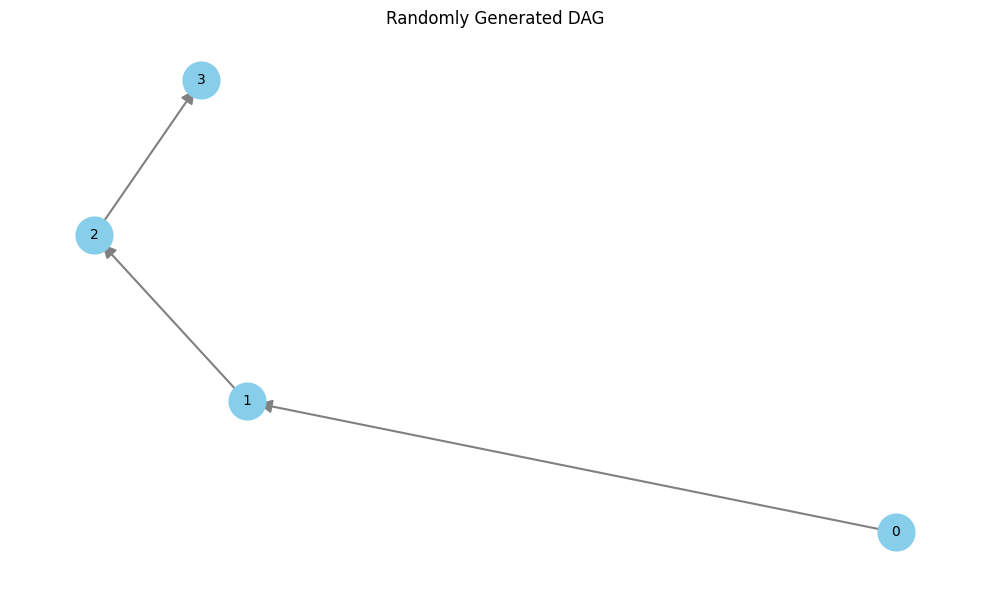

Isolated Nodes: []

Adjacency Matrix:
0	1	0	0
0	0	1	0
0	0	0	1
0	0	0	0

Perturbed Adjacency Matrix:
0	0.9	0	0
0	0	1.0	0
0	0	0	0.9
0	0	0	0

Perturbed matrix written to perturbed_matrix.tab


In [9]:
# import this module, then:
main('cell', total_nodes=4, min_per_rank=3, max_per_rank=4, min_ranks=1, max_ranks=3,percent=50)


DAG visualization saved to gene_dag_1745856382.png


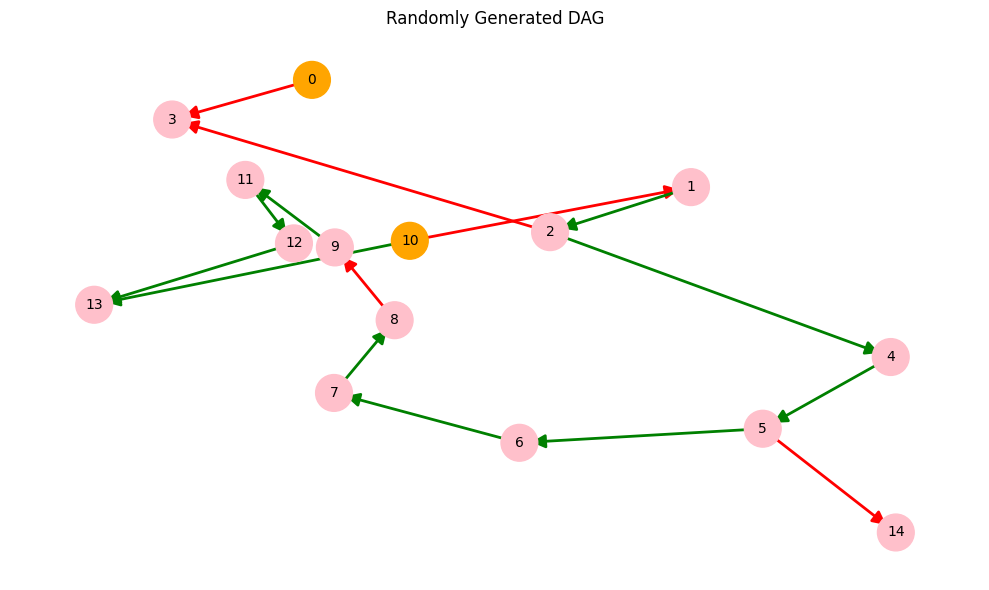

Isolated Nodes: []
1,1,10,2.5,2.0
2,1,1,1.86,2.0
3,2,2,0,-3.34,1.66,2.0,2.0
4,1,2,-2.16,2.0
5,1,4,2.32,2.0
6,1,5,-3.61,2.0
7,1,6,1.45,2.0
8,1,7,0.65,2.0
9,1,8,2.15,2.0
11,1,9,1.0,2.0
12,1,11,-0.9,2.0
13,2,12,10,4.26,2.25,2.0,2.0
14,1,5,1.22,2.0

Gene interactions written to gene_interactions.txt
0,2.7317,2.6391,0.3858,0.5351
10,1.4115,2.7409,3.0331,0.3654

Master regulators written to master_regulators.txt


In [119]:
main('gene', total_nodes=15, min_per_rank=2, max_per_rank=3, min_ranks=1, max_ranks=2, percent=20, inhibit_pct=30, master_regulators=2, num_celltypes=4)